In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import adjustment
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
%matplotlib inline


timestamp_path = "100_0003_Timestamp.mrk"
images_path= 'C:\\Users\\Fedoriv\\Desktop\\main_tasks\\Work\\Pro\\Images'
pos_file = 'output.pos'   # path_to_out_RTKLIB

In [2]:
#adjustment.run_adjustment(pos_file, timestamp_path, images_path)

In [3]:
dataLable = pd.read_csv("output.csv")


def get_file_names(path_name):
    dirpath = os.getcwd()
    os.chdir(path_name)
    lst = [os.path.join(root, name).split("\\")[1] for root, dirs, files in os.walk(".", topdown = False) for name in files]
    os.chdir(dirpath)
    return lst


def get_column(i, content):
    if i < 9:
        return [x[i].replace('[', "").replace(']', "").strip().split(",")[0] for x in content]
    elif i == 12:
        return [x[-1].split(",")[0] for x in content]
    elif i >= 9 and i != 12:
        return [x[9].split(",")[i-9] for x in content]
        


def get_data_from_mrk(path_mrk, path_to_img):
    timestamp_keys = ['photo_number',
                      'GPS_time',
                      'GPS_week',
                      'Phase_compensation_N_CMOS',
                      'Phase_compensation_E_CMOS',
                      'Phase_compensation_UD_CMOS',
                      'Lat',
                      'Lon',
                      'Alt',
                      'Val1',
                      'Val2',
                      'Val3',
                      'Val4']
    lst_img = get_file_names(path_to_img)
    with open(path_mrk) as f:
        content = f.readlines()
    content = [x.split("\t") for x in content]
    dct = {}
    for i, value in enumerate(timestamp_keys):
        dct[value] = get_column(i, content)
    data = pd.DataFrame(data=dct)
    for value in timestamp_keys:
        data[value] = pd.to_numeric(data[value])  
    return data
    
dataLable.columns = ["SourceFile", "gpslatitude", "gpslongitude", "height"]
dataLable.head()

,SourceFile,gpslatitude,gpslongitude,height
0,C:\Users\Fedoriv\Desktop\main_tasks\Work\Pro\I...,34.940890,-85.115461,259.612230
1,C:\Users\Fedoriv\Desktop\main_tasks\Work\Pro\I...,34.940814,-85.115524,259.736120
2,C:\Users\Fedoriv\Desktop\main_tasks\Work\Pro\I...,34.940721,-85.115560,259.957987
3,C:\Users\Fedoriv\Desktop\main_tasks\Work\Pro\I...,34.940616,-85.115604,261.405733
4,C:\Users\Fedoriv\Desktop\main_tasks\Work\Pro\I...,34.940523,-85.115646,261.162110


2.2817426414904107e-05


C:\Users\Fedoriv\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


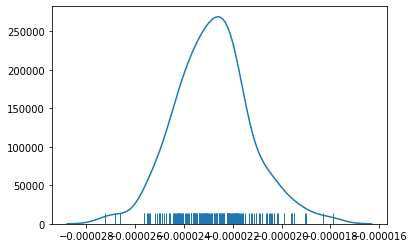

In [4]:
import seaborn as sns

data = get_data_from_mrk(timestamp_path, images_path)
data.head()


sns.distplot(data["Lat"] - dataLable["gpslatitude"],hist=False, rug=True)


print(mean_absolute_error(data["Lat"],dataLable["gpslatitude"]))

2.2817426414904107e-05


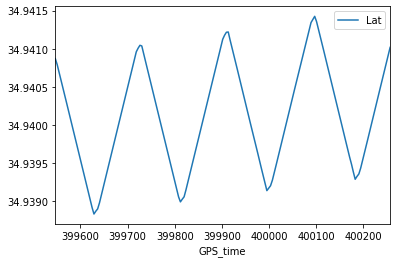

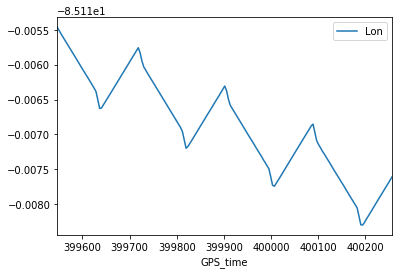

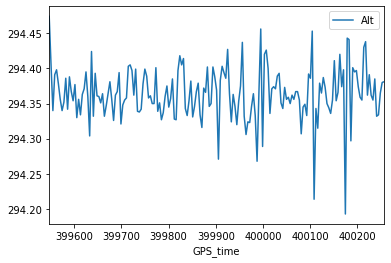

In [5]:
data.plot(x="GPS_time", y='Lat')
data.plot(x="GPS_time", y='Lon')
data.plot(x="GPS_time", y='Alt')

key = mean_absolute_error(data["Lat"], dataLable["gpslatitude"])

print(key)

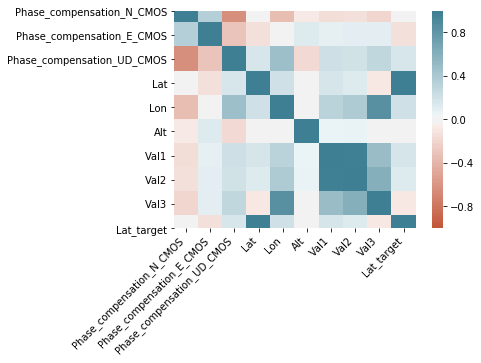

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
data = data.drop(['photo_number','GPS_time','GPS_week','Val4'], axis=1)

data["Lat_target"] = dataLable["gpslatitude"]
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

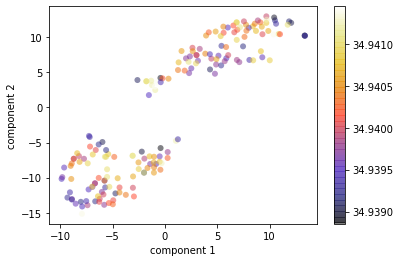

In [7]:
from sklearn.manifold import TSNE


projected = TSNE(n_components=2).fit_transform(data.loc[:, data.columns != 'Lat_target'])

plt.scatter(projected[:, 0], projected[:, 1],
            c=data.Lat_target, edgecolor='none', alpha=0.5, cmap="CMRmap")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

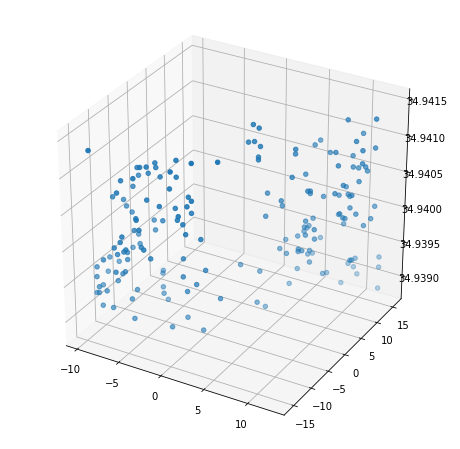

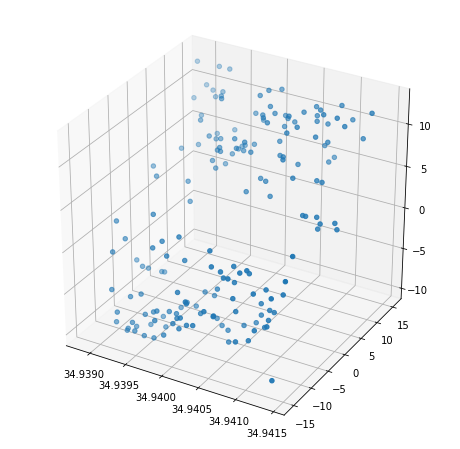

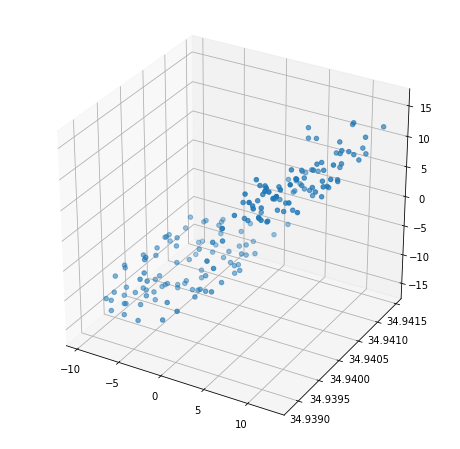

In [8]:
from mpl_toolkits import mplot3d

projected3 = TSNE(n_components=2).fit_transform(data.loc[:, data.columns != 'Lat_target'])
fig = plt.figure(figsize=(8, 8))  
ax = plt.axes(projection='3d')
projected = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
ax.scatter3D(projected3[:, 0], projected3[:, 1],data.Lat_target, cmap="CMRmap");


fig = plt.figure(figsize=(8, 8))  
ax = plt.axes(projection='3d')
projected = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
ax.scatter3D(data.Lat_target, projected3[:, 1],projected3[:, 0], cmap="CMRmap");

fig = plt.figure(figsize=(8, 8))  
ax = plt.axes(projection='3d')
projected = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
ax.scatter3D(projected3[:, 0], data.Lat_target,projected3[:, 1], cmap="CMRmap");

In [9]:
for name in data.columns:
    if name != "Lat_target":
        data[name] = (data[name]-data[name].min())/(data[name].max()-data[name].min())

def scale_data_column(data, name, min_col=None, max_col=None):
    if not (min_col and max_col):
        min_col = data[name].min()
        max_col = data[name].max()   
    data[name] = (data[name] - min_col) / (max_col - min_col)
    return data, min_col, max_col    


def de_scale_data_column(array, min_col, max_col):
    array = array * (max_col - min_col) + min_col
    return array

data["Lat_target"], min_Lat, max_Lat = scale_data_column(data, "Lat_target")

In [10]:
data

,Phase_compensation_N_CMOS,Phase_compensation_E_CMOS,Phase_compensation_UD_CMOS,Lat,Lon,Alt,Val1,Val2,Val3,Lat_target
0,0.500000,0.882979,0.714286,0.785812,1.000000,1.000000,0.914067,0.940112,0.992096,0.500000
1,0.421875,0.553191,0.928571,0.756221,0.983316,0.754448,0.876300,0.951965,1.000000,0.421875
2,0.429688,0.521277,0.928571,0.718543,0.967296,0.523132,0.685276,0.752963,0.887002,0.429688
3,0.453125,0.446809,0.928571,0.680800,0.951921,0.704626,0.755337,0.738615,0.899005,0.453125
4,0.460938,0.425532,0.857143,0.642671,0.936621,0.729537,0.523810,0.542732,0.776639,0.460938
...,...,...,...,...,...,...,...,...,...,...
178,0.890625,0.574468,0.500000,0.689739,0.182418,0.494662,0.185003,0.233936,0.088115,0.890625
179,0.898438,0.500000,0.428571,0.728453,0.197415,0.501779,0.475096,0.575172,0.207553,0.898438
180,0.843750,0.542553,0.571429,0.766116,0.213008,0.612100,0.197044,0.252027,0.204333,0.843750
181,0.867188,0.595745,0.571429,0.804696,0.228799,0.665480,0.200328,0.254523,0.211651,0.867188


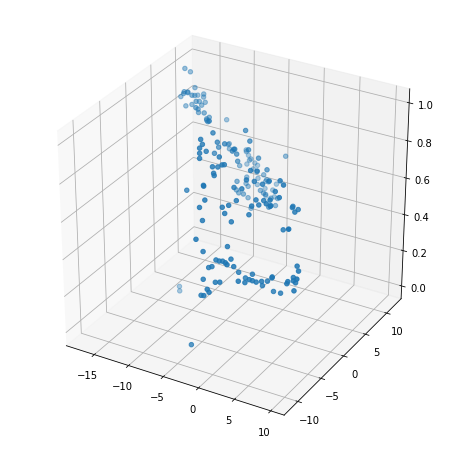

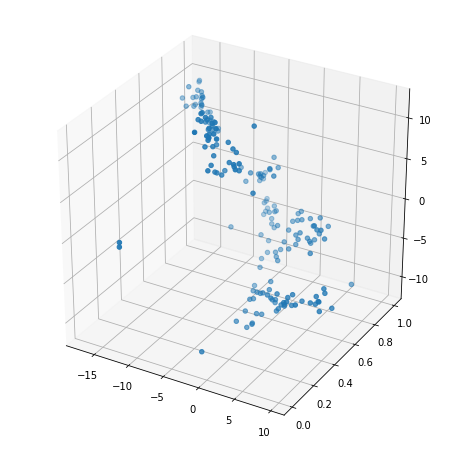

In [11]:
projected3 = TSNE(n_components=2).fit_transform(data.loc[:, data.columns != 'Lat_target'])
fig = plt.figure(figsize=(8, 8))  
ax = plt.axes(projection='3d')
projected = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
ax.scatter3D(projected3[:, 0], projected3[:, 1],data.Lat_target, cmap="CMRmap");


fig = plt.figure(figsize=(8, 8))  
ax = plt.axes(projection='3d')
projected = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
ax.scatter3D(projected3[:, 0], data.Lat_target,projected3[:, 1], cmap="CMRmap");

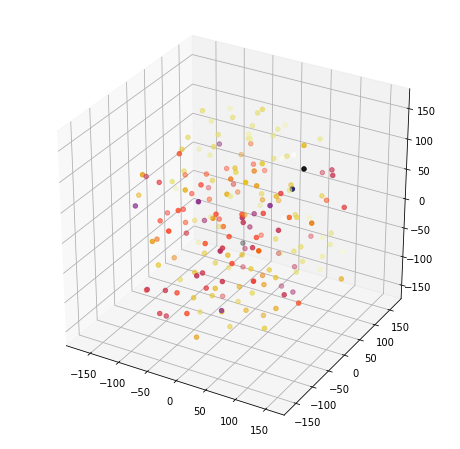

In [12]:
projected3 = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
fig = plt.figure(figsize=(8, 8))  
ax = plt.axes(projection='3d')
projected = TSNE(n_components=3).fit_transform(data.loc[:, data.columns != 'Lat_target'])
ax.scatter3D(projected3[:, 0], projected3[:, 1],projected3[:, 2], c=data.Lat_target, cmap="CMRmap");

In [13]:
from sklearn.metrics import mean_squared_error

def model_fit(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_predict_test = model.predict(X_test)
    y_predict_train = model.predict(X_train)
    
    all_predict_train = model.predict(data.drop('Lat_target', 1))
    
    y_predict_test = de_scale_data_column(y_predict_test, min_Lat, max_Lat)
    y_predict_train = de_scale_data_column(y_predict_train, min_Lat, max_Lat)
    y_test = de_scale_data_column(y_test, min_Lat, max_Lat)
    y_train = de_scale_data_column(y_train, min_Lat, max_Lat)
    
    print("###########################Model_report############################################################")
    print("mean_squared_error on train : ",mean_squared_error(y_predict_train, y_train))
    print("mean_squared_error on test : ",mean_squared_error(y_predict_test, y_test))
    print("mean_absolute_error on train : ",mean_absolute_error(y_predict_train, y_train))
    print("mean_absolute_error on test : ",mean_absolute_error(y_predict_test, y_test))
    #print(mean_absolute_error(y_predict_test, y_test)/key)
    
    #print(mean_absolute_error(all_predict_train, data['Lat_target'])/key)
    print("###########################End_of_report##########################################################")

In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
model = ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Lat_target', 1), data['Lat_target'], test_size = .2, random_state=10) #split the data
X_train

,Phase_compensation_N_CMOS,Phase_compensation_E_CMOS,Phase_compensation_UD_CMOS,Lat,Lon,Alt,Val1,Val2,Val3
7,0.437500,0.489362,0.928571,0.528115,0.891362,0.523132,0.783251,0.811603,0.940867
26,0.859375,0.765957,0.571429,0.133540,0.622288,0.597865,0.488232,0.563319,0.732728
75,0.914062,0.797872,0.357143,0.273767,0.457648,0.498221,0.279693,0.336245,0.638466
182,0.812500,0.574468,0.571429,0.843067,0.244107,0.669039,0.638752,0.771678,0.275761
52,0.421875,0.500000,0.928571,0.659138,0.722540,0.733096,0.344828,0.409233,0.634953
...,...,...,...,...,...,...,...,...,...
113,0.593750,0.606383,0.928571,0.193921,0.315928,0.266904,0.233716,0.266999,0.273419
64,0.500000,0.595745,1.000000,0.200585,0.539684,0.647687,0.377668,0.456644,0.688232
15,0.429688,0.510638,0.928571,0.222656,0.769281,0.487544,0.258347,0.333125,0.633489
125,0.843750,0.734043,0.571429,0.437541,0.302541,0.711744,0.113848,0.066750,0.121487


In [16]:
model_fit(model, X_train, X_test, y_train, y_test)

###########################Model_report############################################################
mean_squared_error on train :  2.788532052054422e-07
mean_squared_error on test :  2.065240432541362e-07
mean_absolute_error on train :  0.0004607316145608691
mean_absolute_error on test :  0.00041440153220675583
###########################End_of_report##########################################################


In [17]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
model_fit(model, X_train, X_test, y_train, y_test)

###########################Model_report############################################################
mean_squared_error on train :  6.969944796695648e-09
mean_squared_error on test :  2.346921544709438e-09
mean_absolute_error on train :  5.683754612664299e-05
mean_absolute_error on test :  4.0835190442808995e-05
###########################End_of_report##########################################################


In [ ]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=1.0)
model_fit(model, X_train, X_test, y_train, y_test)

In [20]:
model_ridge = Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.0001)
model_fit(model_ridge, X_train, X_test, y_train, y_test)

###########################Model_report############################################################
mean_squared_error on train :  3.4580204064482707e-31
mean_squared_error on test :  1.3645161603822908e-30
mean_absolute_error on train :  4.866731066850001e-17
mean_absolute_error on test :  1.9203857723245952e-16
###########################End_of_report##########################################################


In [ ]:
projected = TSNE(n_components=1).fit_transform(data.loc[:, data.columns != 'Lat_target'])

plt.scatter(projected[:, 0], data.Lat_target,edgecolor='none', alpha=0.5, cmap="CMRmap")
plt.xlabel('component 1')
plt.ylabel('Lat_target')
plt.colorbar();

In [22]:
predict_lat = model.predict(data.loc[:, data.columns != 'Lat_target'].values)

def de_scale_data_column(array, min_col, max_col):
    array = array * (max_col - min_col) + min_col
    return array

predict_lat = de_scale_data_column(predict_lat, min_Lat, max_Lat)

predict_lat

array([34.94022055, 34.93999529, 34.9400283 , 34.94004421, 34.94007119,
       34.94002914, 34.94006668, 34.94003541, 34.94006081, 34.9401217 ,
       34.94017673, 34.94013328, 34.94018683, 34.94019711, 34.94001243,
       34.94001828, 34.93995276, 34.93999208, 34.93992643, 34.9398576 ,
       34.94000027, 34.93945784, 34.94054412, 34.94036683, 34.94075142,
       34.94088403, 34.94101081, 34.94093716, 34.9409371 , 34.94064302,
       34.94060622, 34.94066821, 34.94050011, 34.94068621, 34.94080626,
       34.94089539, 34.94097234, 34.94083614, 34.94093301, 34.94073407,
       34.94075174, 34.94066012, 34.94064548, 34.94075644, 34.94087504,
       34.94056634, 34.94058034, 34.93992071, 34.93990627, 34.94002751,
       34.93999595, 34.93996897, 34.94000617, 34.9400364 , 34.94005167,
       34.94004099, 34.9400497 , 34.94006897, 34.93998422, 34.94005941,
       34.94018643, 34.94031758, 34.94018104, 34.94017639, 34.94016421,
       34.94012872, 34.94011318, 34.94025867, 34.94070358, 34.94

In [23]:
print(mean_absolute_error(predict_lat, data["Lat"]) / mean_absolute_error(data["Lat"],dataLable["gpslatitude"])) #####!
mean_absolute_error(data["Lat"],dataLable["gpslatitude"])

1.0000114544905667


34.44599965316342

In [ ]:
# X_test, y_train, y_test

predict_lat_test = model_ridge.predict(X_test)
predict_lat_test = de_scale_data_column(predict_lat_test, min_Lat, max_Lat)
y_test = de_scale_data_column(y_test, min_Lat, max_Lat) #!#!#!#!#!#!#!#!#!#!#!#!###########!!!!
mean_absolute_error(predict_lat_test, y_test)

In [ ]:
predict_lat_test

In [ ]:
y_test

In [ ]:
## Lets concat our ideas 

In [ ]:
import seaborn as sns
sns.distplot(y_test, hist=False, rug=True);

In [ ]:
sns.distplot(predict_lat_test - y_test,hist=False, rug=True)

In [ ]:
max_Lat - min_Lat

In [ ]:
from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, average

In [ ]:
def main(file1, file2):
    #file1, file2 = sys.argv[1:1+2]
    # read images as 2D arrays (convert to grayscale for simplicity)
    img1 = to_grayscale(imread(file1).astype(float))
    img2 = to_grayscale(imread(file2).astype(float))
    # compare
    n_m, n_0 = compare_images(img1, img2)
    print("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size)
    print("Zero norm:", n_0, "/ per pixel:", n_0*1.0/img1.size)
    
    


In [ ]:
def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return m_norm, z_norm

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

In [ ]:
main(dataLable["SourceFile"].iloc[0], dataLable["SourceFile"].iloc[1])

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
model = LinearRegression()

In [26]:
model_fit(model, X_train, X_test, y_train, y_test)

###########################Model_report############################################################
mean_squared_error on train :  1.0374061219344812e-30
mean_squared_error on test :  2.7290323207645815e-30
mean_absolute_error on train :  1.4600193200550003e-16
mean_absolute_error on test :  3.8407715446491904e-16
###########################End_of_report##########################################################


In [27]:
data

,Phase_compensation_N_CMOS,Phase_compensation_E_CMOS,Phase_compensation_UD_CMOS,Lat,Lon,Alt,Val1,Val2,Val3,Lat_target
0,0.500000,0.882979,0.714286,0.785812,1.000000,1.000000,0.914067,0.940112,0.992096,0.500000
1,0.421875,0.553191,0.928571,0.756221,0.983316,0.754448,0.876300,0.951965,1.000000,0.421875
2,0.429688,0.521277,0.928571,0.718543,0.967296,0.523132,0.685276,0.752963,0.887002,0.429688
3,0.453125,0.446809,0.928571,0.680800,0.951921,0.704626,0.755337,0.738615,0.899005,0.453125
4,0.460938,0.425532,0.857143,0.642671,0.936621,0.729537,0.523810,0.542732,0.776639,0.460938
...,...,...,...,...,...,...,...,...,...,...
178,0.890625,0.574468,0.500000,0.689739,0.182418,0.494662,0.185003,0.233936,0.088115,0.890625
179,0.898438,0.500000,0.428571,0.728453,0.197415,0.501779,0.475096,0.575172,0.207553,0.898438
180,0.843750,0.542553,0.571429,0.766116,0.213008,0.612100,0.197044,0.252027,0.204333,0.843750
181,0.867188,0.595745,0.571429,0.804696,0.228799,0.665480,0.200328,0.254523,0.211651,0.867188
